# MACD Calculator

## Weekly MACD Trading Strategy

[*********************100%%**********************]  1 of 1 completed


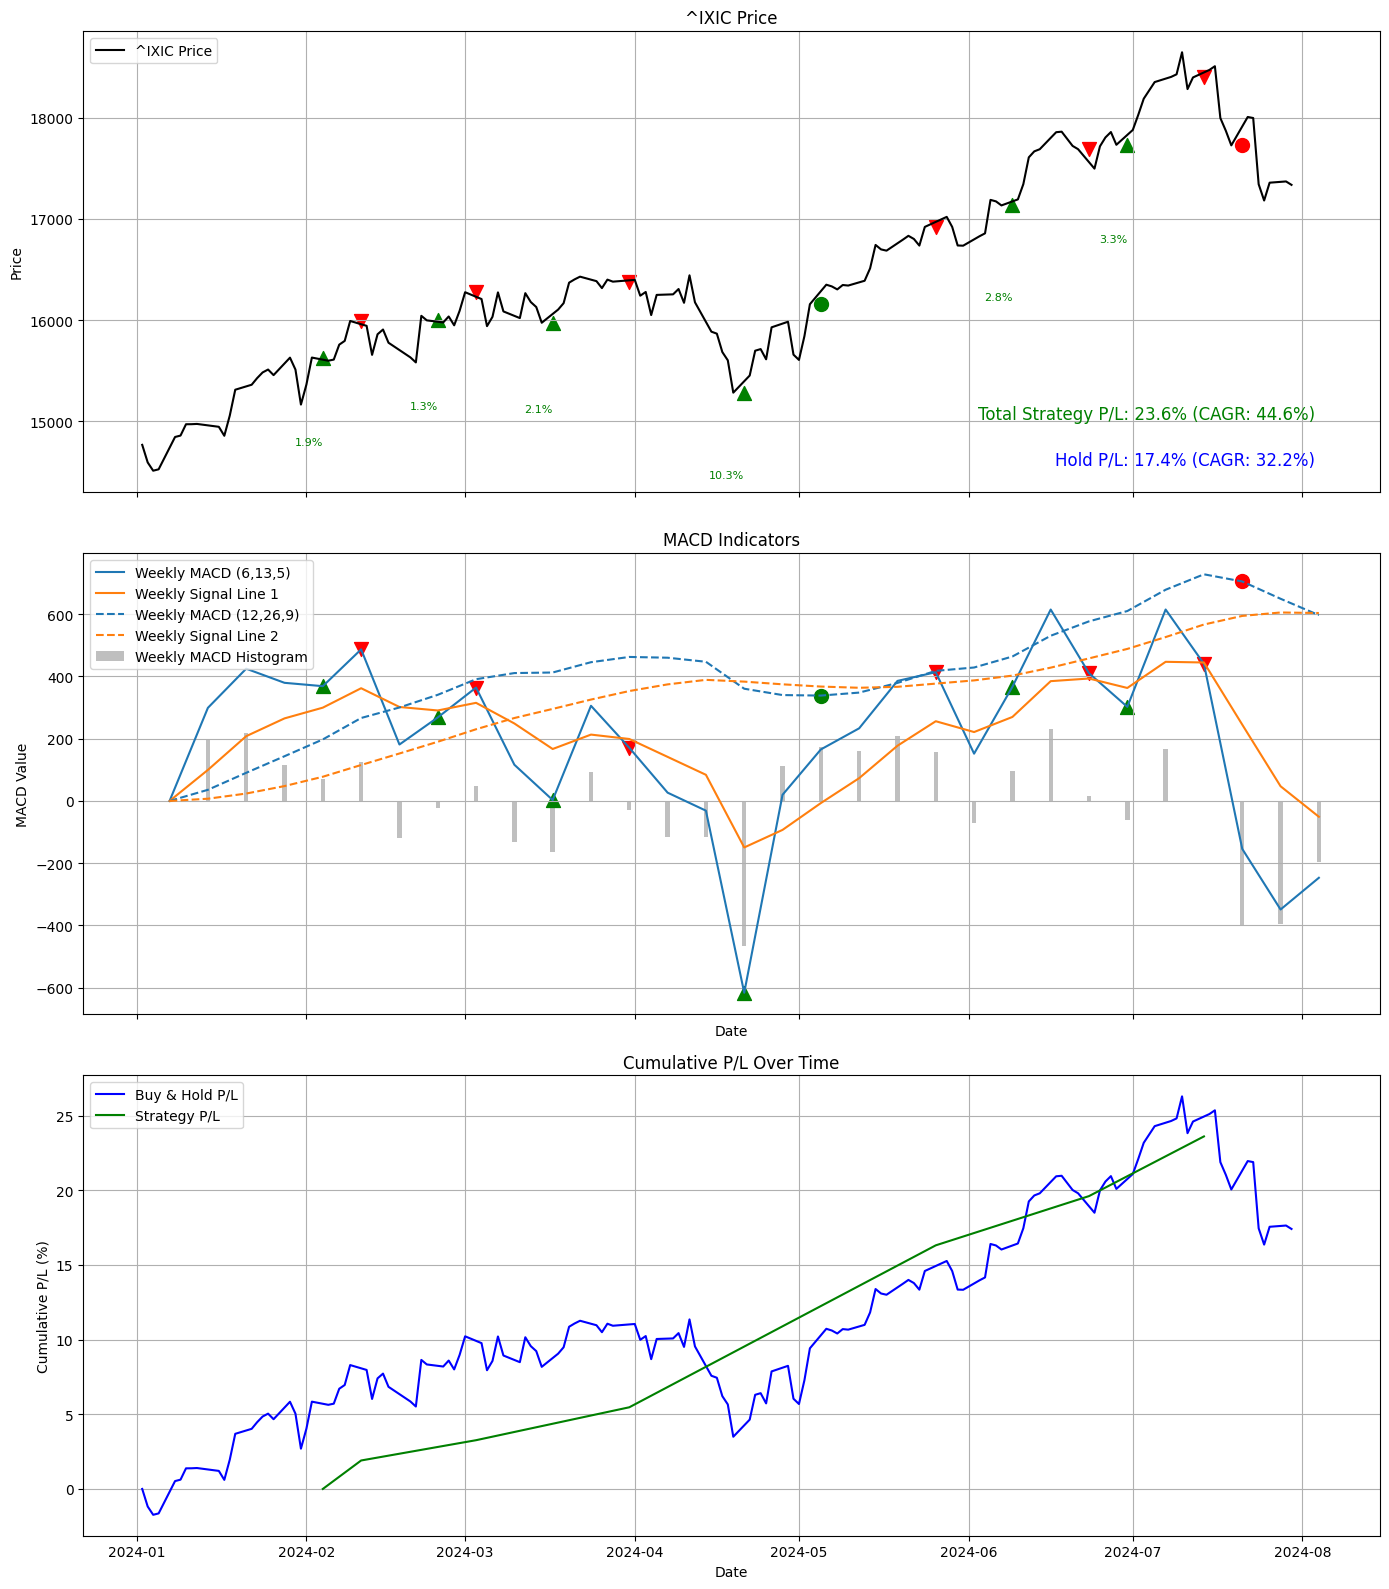

[*********************100%%**********************]  1 of 1 completed

    Buy Date  Sell Date     Buy Price    Sell Price  Profit/Loss (%)
0 2024-02-04 2024-02-11  15660.208096  15958.678836         1.905918
1 2024-02-25 2024-03-03  16028.813953  16242.390549         1.332454
2 2024-03-17 2024-03-31  16005.116262  16346.701041         2.134222
3 2024-04-21 2024-05-26  15312.573785  16886.947484        10.281575
4 2024-06-09 2024-06-23  17167.397121  17653.980656         2.834347
5 2024-06-30 2024-07-14  17768.064809  18361.652320         3.340755


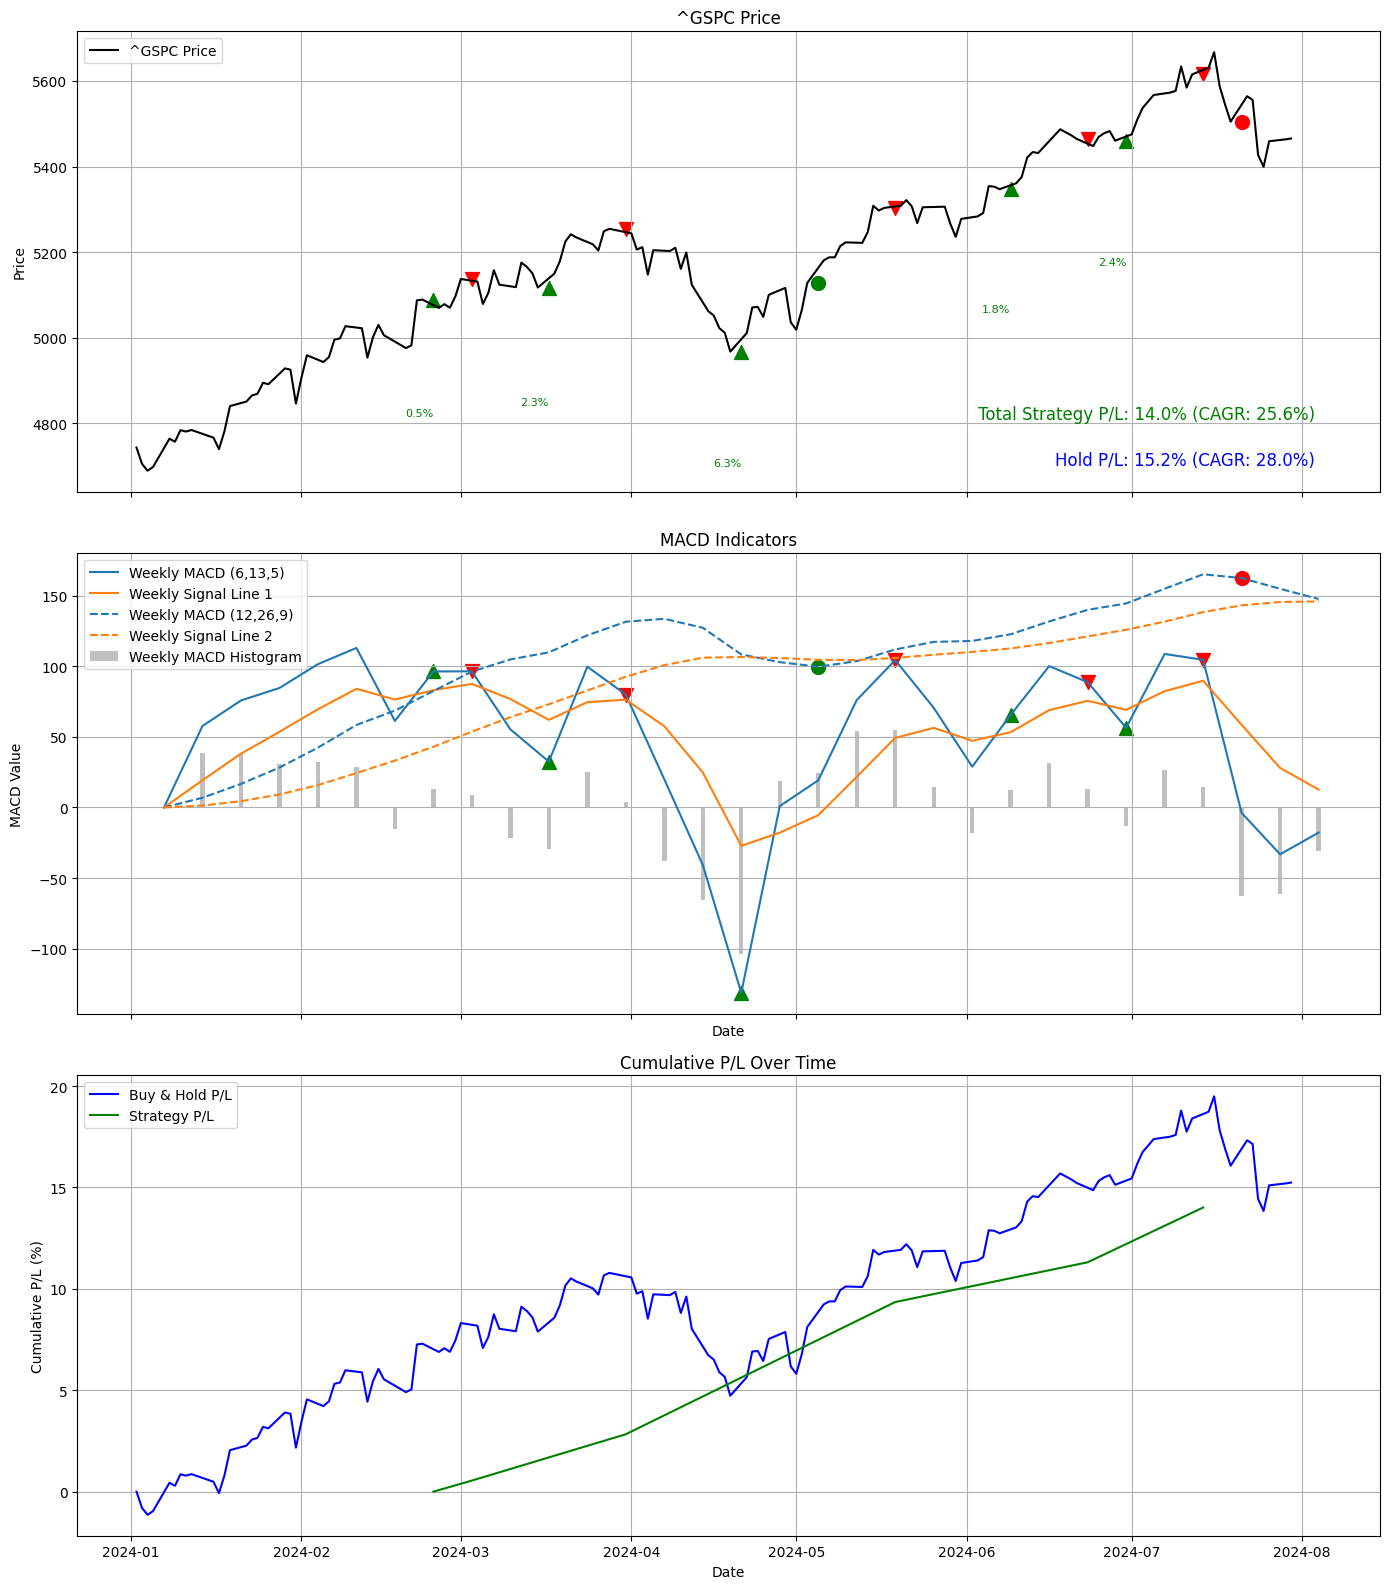

[*********************100%%**********************]  1 of 1 completed

    Buy Date  Sell Date    Buy Price   Sell Price  Profit/Loss (%)
0 2024-02-25 2024-03-03  5098.977404  5126.805918         0.545767
1 2024-03-17 2024-03-31  5127.324023  5243.841397         2.272479
2 2024-04-21 2024-05-19  4977.164440  5292.663479         6.338931
3 2024-06-09 2024-06-23  5357.684215  5453.690877         1.791943
4 2024-06-30 2024-07-14  5471.400940  5604.119397         2.425676


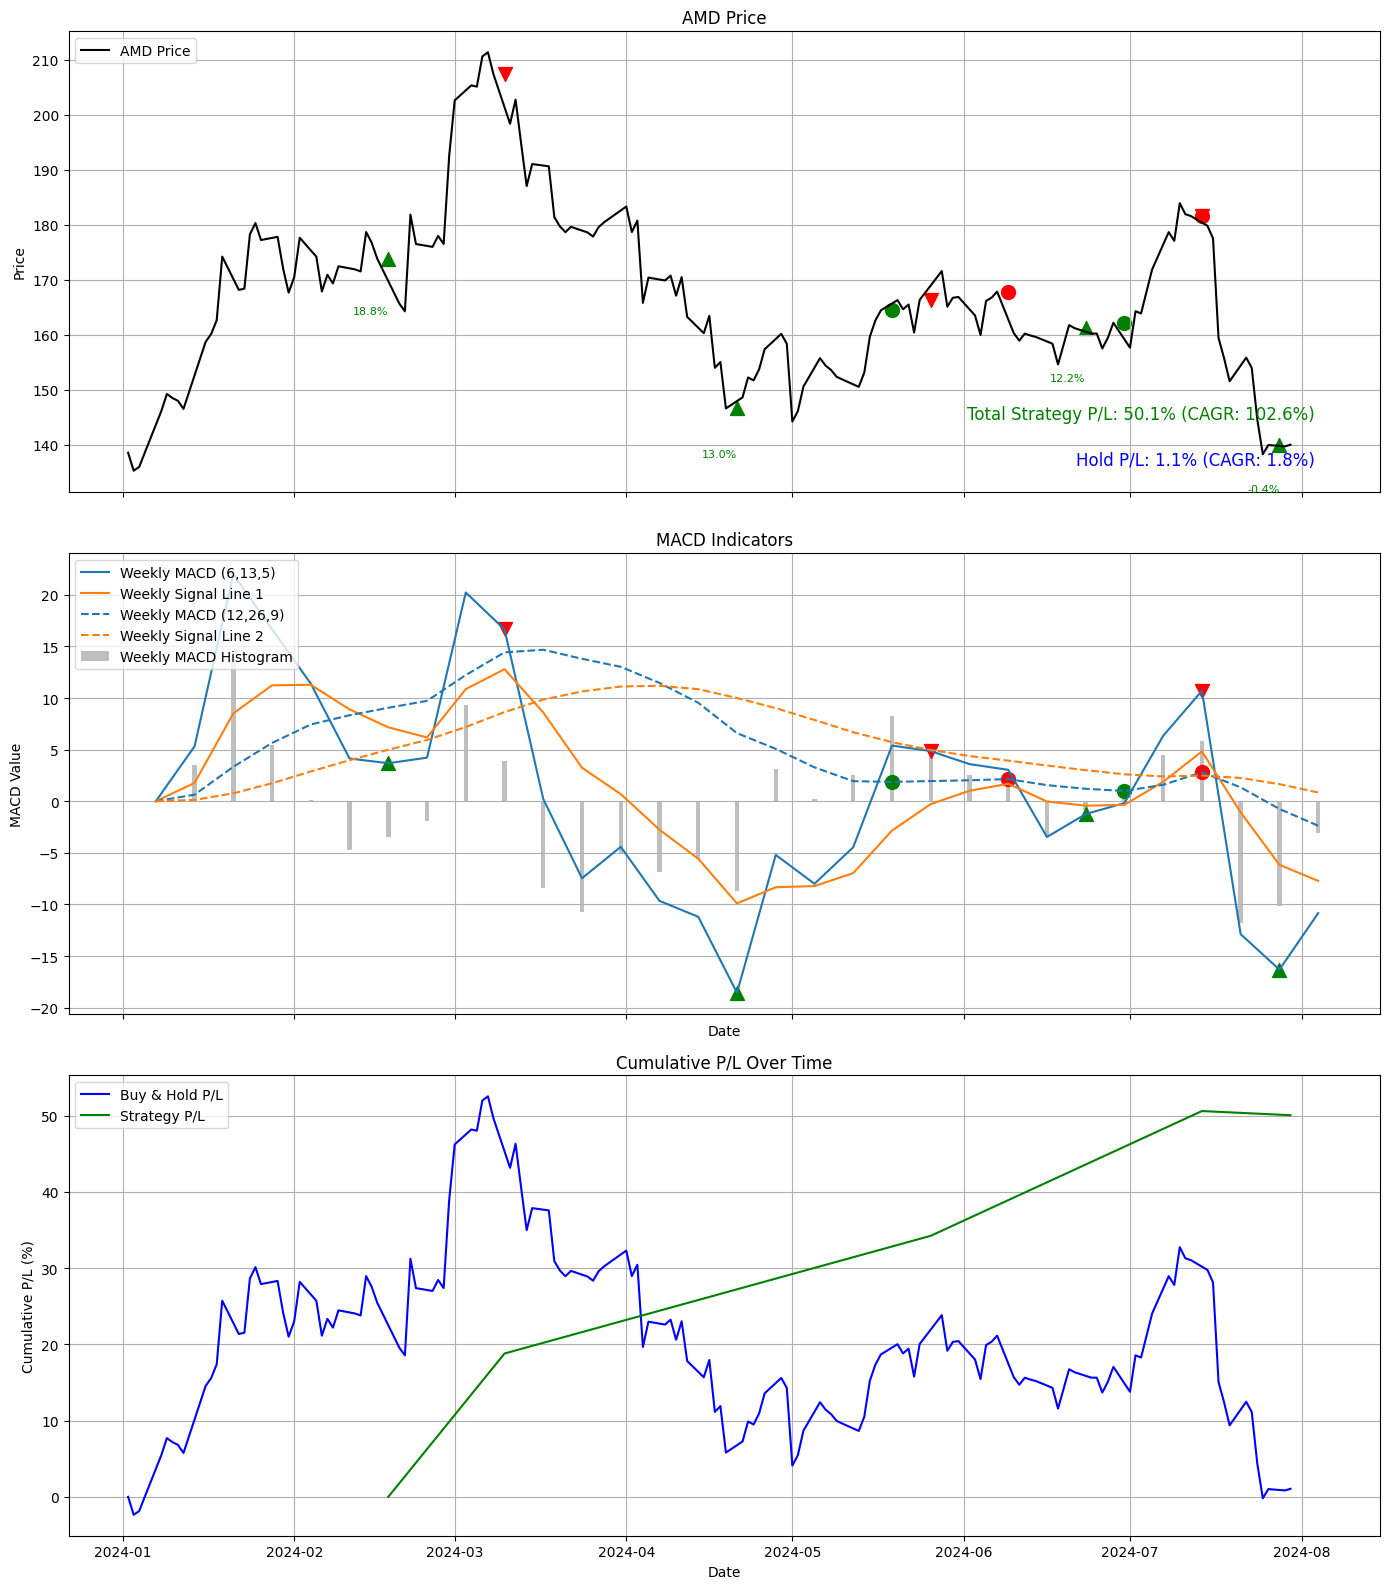

[*********************100%%**********************]  1 of 1 completed

    Buy Date  Sell Date   Buy Price  Sell Price  Profit/Loss (%)
0 2024-02-18 2024-03-10  174.217735  206.975219        18.802612
1 2024-04-21 2024-05-26  146.933279  166.027281        12.995015
2 2024-06-23 2024-07-14  161.552456  181.246781        12.190669
3 2024-07-28 2024-07-30  140.269986  139.759913        -0.363636


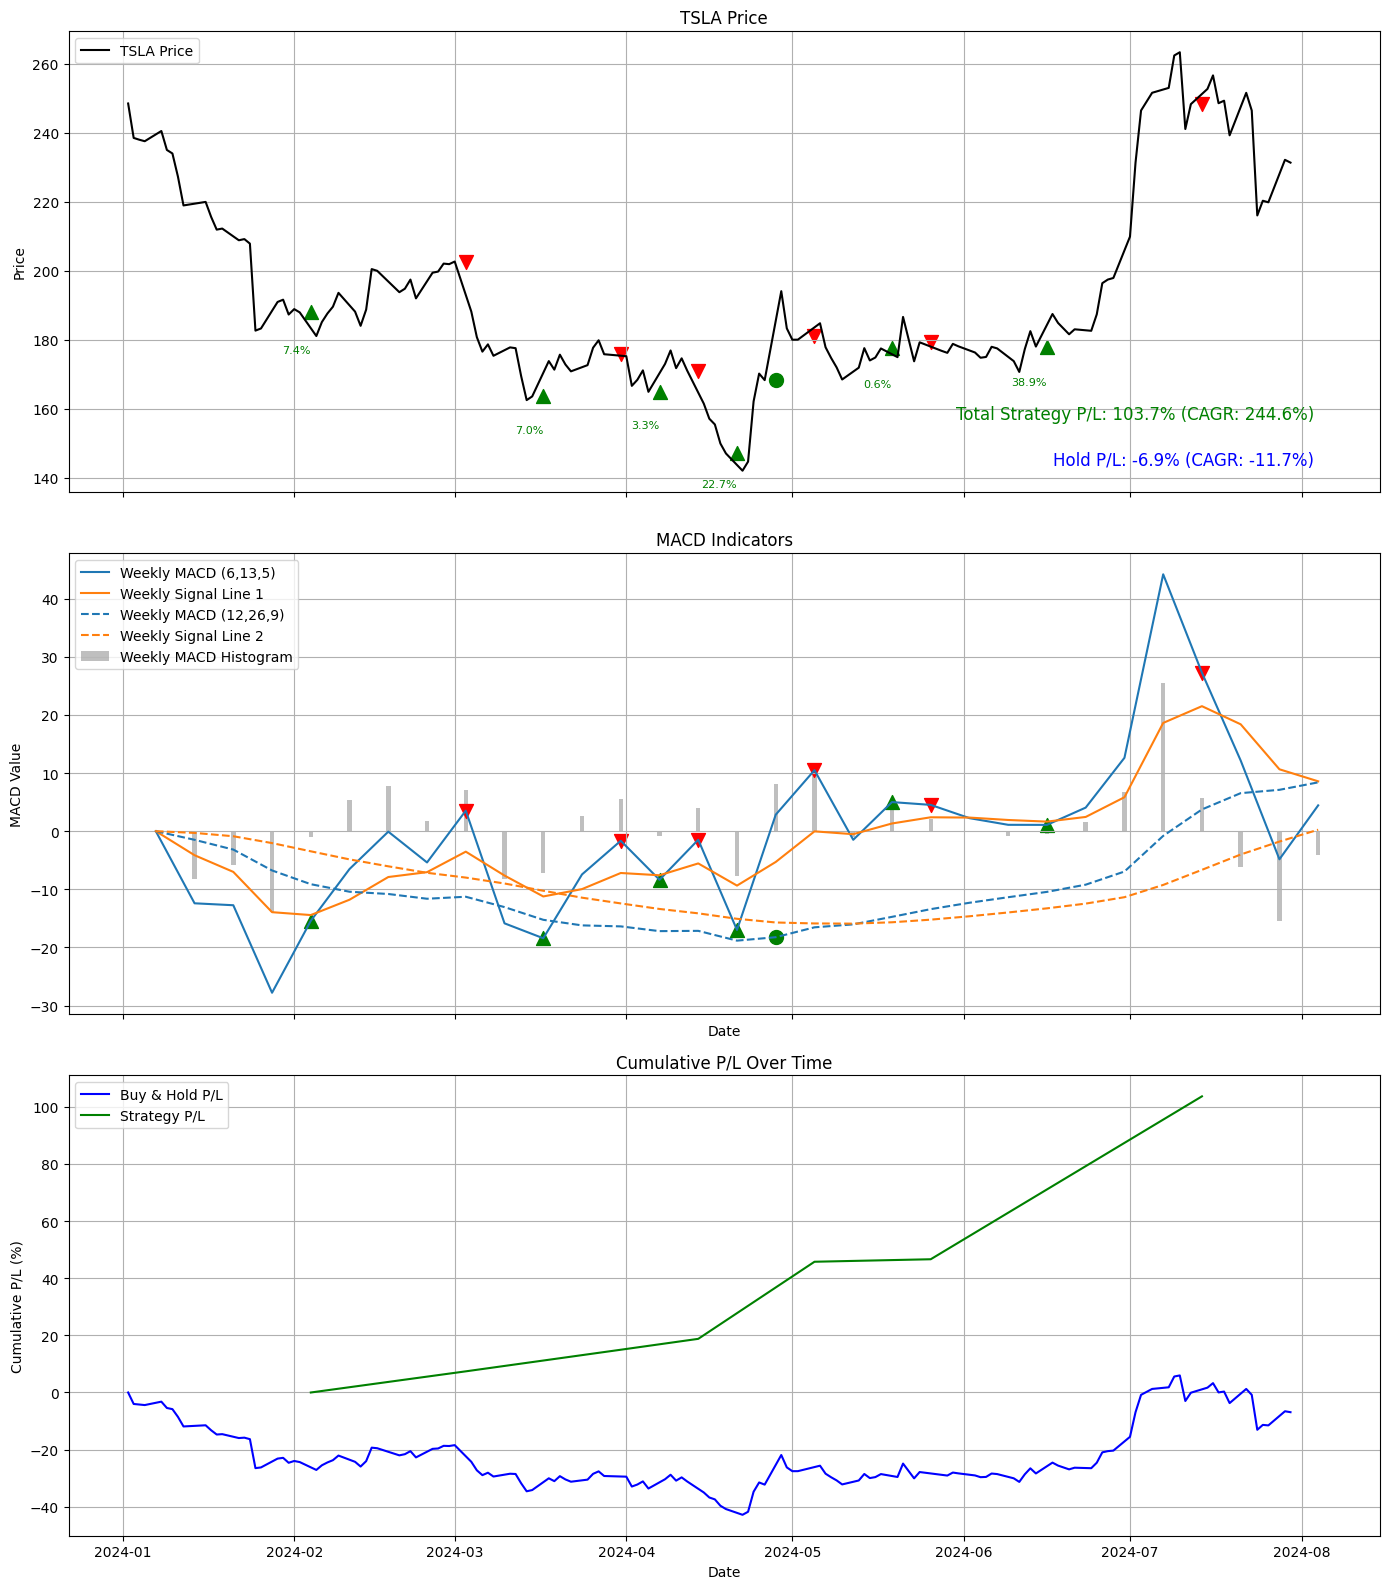

[*********************100%%**********************]  1 of 1 completed

    Buy Date  Sell Date   Buy Price  Sell Price  Profit/Loss (%)
0 2024-02-04 2024-03-03  188.285824  202.234719         7.408362
1 2024-03-17 2024-03-31  163.897147  175.438413         7.041774
2 2024-04-07 2024-04-14  165.229794  170.707903         3.315449
3 2024-04-21 2024-05-05  147.344103  180.827622        22.724709
4 2024-05-19 2024-05-26  177.814927  178.881525         0.599836
5 2024-06-16 2024-07-14  178.366014  247.733536        38.890548


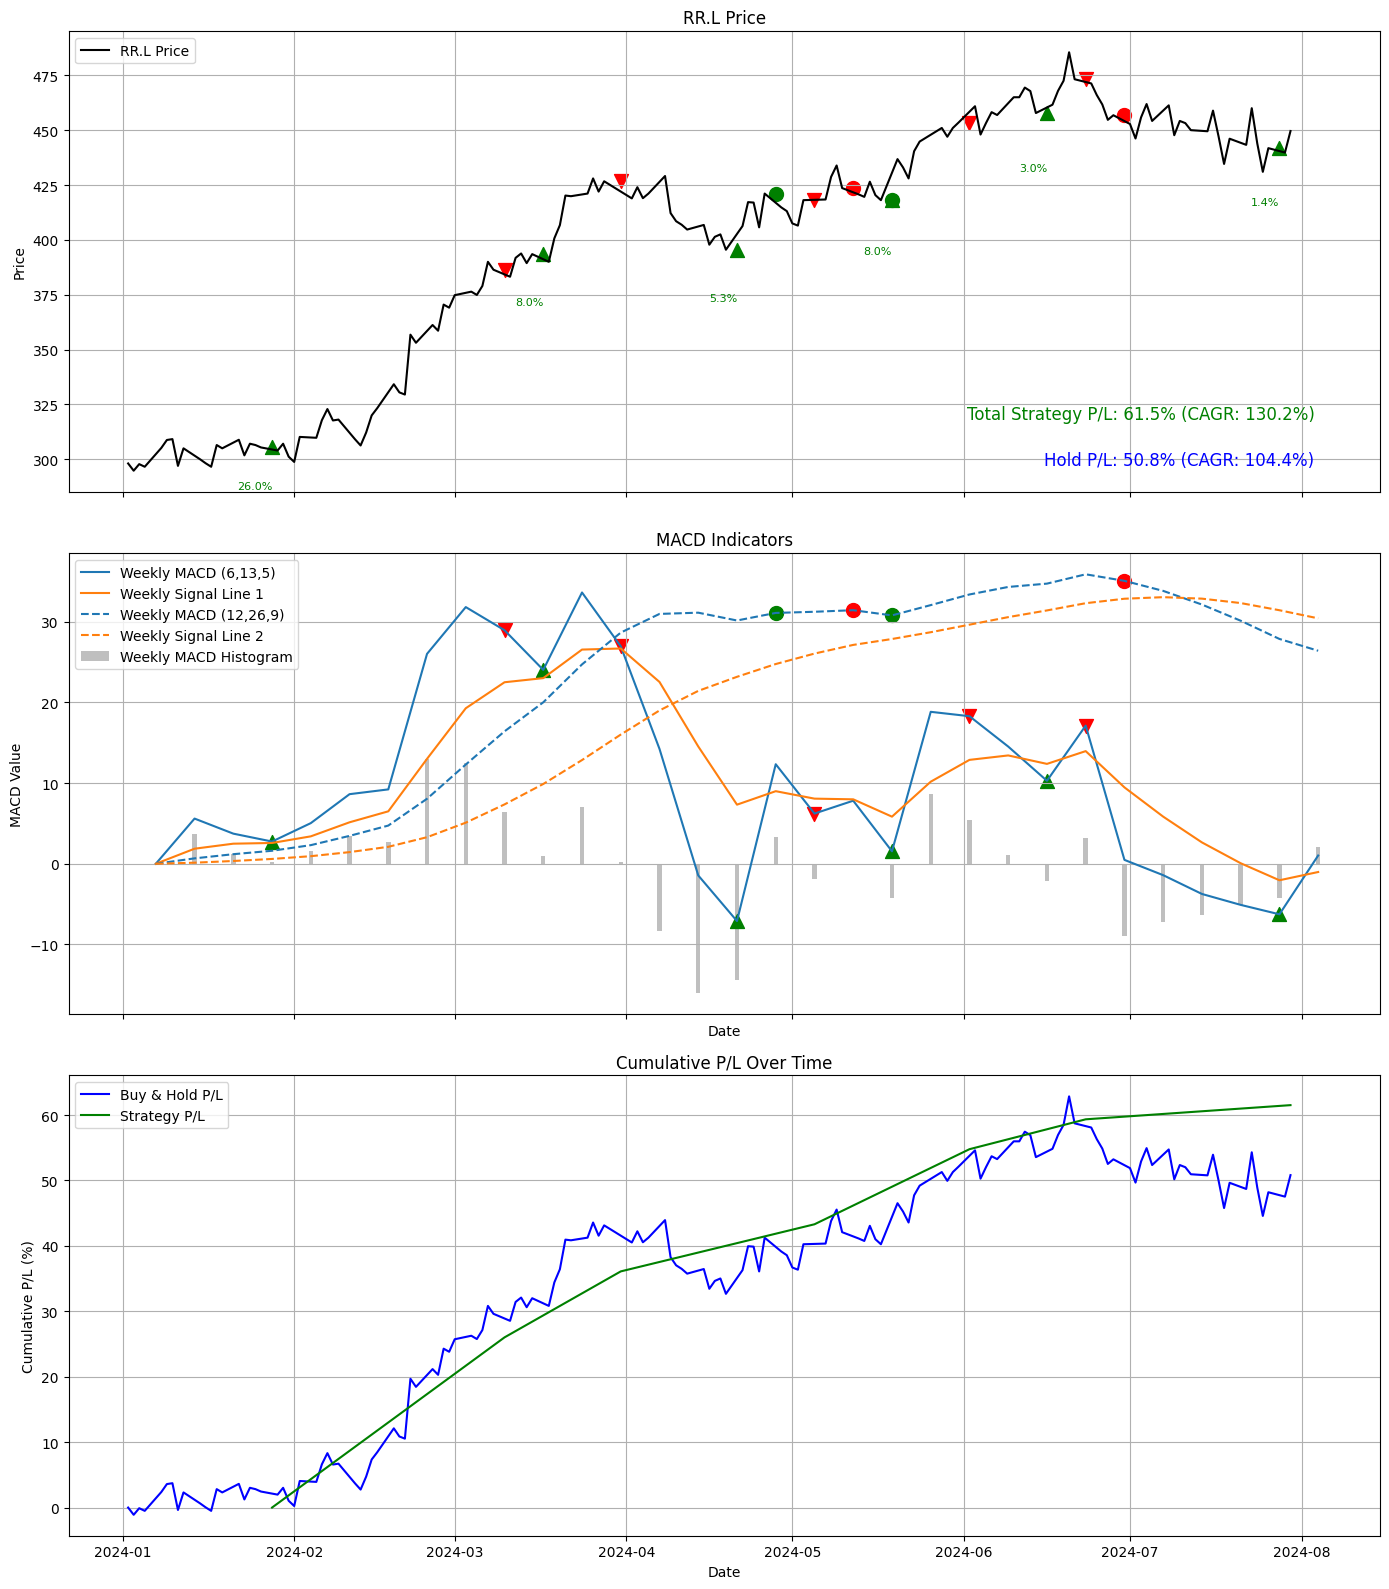

    Buy Date  Sell Date   Buy Price  Sell Price  Profit/Loss (%)
0 2024-01-28 2024-03-10  306.010794  385.627194        26.017514
1 2024-03-17 2024-03-31  394.287000  425.846612         8.004223
2 2024-04-21 2024-05-05  396.291000  417.263806         5.292274
3 2024-05-19 2024-06-02  418.936206  452.493194         8.010047
4 2024-06-16 2024-06-23  458.715588  472.253612         2.951289
5 2024-07-28 2024-07-30  442.683588  448.700806         1.359259


In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import numpy as np

def calculate_cagr(start_value, end_value, start_date, end_date):
    years = (end_date - start_date).days / 365.25
    cagr = (end_value / start_value) ** (1 / years) - 1
    return cagr * 100

def calculate_cumulative_contribution(cumulative_pl, trade_dates, initial_capital=6000, yearly_contribution=20000):
    capital = initial_capital
    total_invested = initial_capital
    total_value = []
    
    # Generate monthly contribution dates
    start_date = trade_dates[0][0]
    end_date = trade_dates[-1][1]
    contribution_dates = pd.date_range(start=start_date, end=end_date, freq='ME')

    for date in contribution_dates:
        capital += yearly_contribution / 12  # Monthly contribution
        total_invested += yearly_contribution / 12
        if date >= trade_dates[0][0]:
            for i in range(len(trade_dates)):
                if date <= trade_dates[i][1]:
                    break
            total_value.append(capital * (1 + cumulative_pl[i] / 100))
        else:
            total_value.append(capital)
    
    return total_value[-1], total_invested

def calculate_macd(df, short_window, long_window, signal_window, suffix=''):
    df[f'EMA_short{suffix}'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df[f'EMA_long{suffix}'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    df[f'MACD{suffix}'] = df[f'EMA_short{suffix}'] - df[f'EMA_long{suffix}']
    df[f'Signal_Line{suffix}'] = df[f'MACD{suffix}'].ewm(span=signal_window, adjust=False).mean()
    return df

def calculate_gradients(df, suffix=''):
    df[f'MACD_Gradient{suffix}'] = np.gradient(df[f'MACD{suffix}'])
    return df

def find_turning_points(df, suffix=''):
    turning_points_buy = []
    turning_points_sell = []
    
    for i in range(1, len(df)-1):
        if df[f'MACD_Gradient{suffix}'].iloc[i-1] < 0 and df[f'MACD_Gradient{suffix}'].iloc[i] >= 0:
            turning_points_buy.append((df.index[i], df['Close'].iloc[i], df[f'MACD{suffix}'].iloc[i]))
        if df[f'MACD_Gradient{suffix}'].iloc[i-1] > 0 and df[f'MACD_Gradient{suffix}'].iloc[i] <= 0:
            turning_points_sell.append((df.index[i], df['Close'].iloc[i], df[f'MACD{suffix}'].iloc[i]))
    
    return turning_points_buy, turning_points_sell

def filter_signals(buy_signals, sell_signals, df):
    filtered_buy_signals = []
    filtered_sell_signals = []
    last_sell_date = None
    
    for buy_signal in buy_signals:
        if last_sell_date is None or buy_signal[0] > last_sell_date:
            filtered_buy_signals.append(buy_signal)
            corresponding_sell_signal = next((sell_signal for sell_signal in sell_signals if sell_signal[0] > buy_signal[0]), None)
            if corresponding_sell_signal:
                filtered_sell_signals.append(corresponding_sell_signal)
                last_sell_date = corresponding_sell_signal[0]
    
    return filtered_buy_signals, filtered_sell_signals

def calculate_profit_loss(buy_signals, sell_signals, df_price, transaction_fee=0.002):
    profit_loss = []
    cumulative_pl = []
    capital = 100  # Starting capital (arbitrary value for percentage calculation)
    trade_dates = []
    trade_records = []  # To store trade details

    for i in range(len(buy_signals)):
        buy_price = buy_signals[i][1] * (1 + transaction_fee)
        if i < len(sell_signals):
            sell_price = sell_signals[i][1] * (1 - transaction_fee)
            sell_date = sell_signals[i][0]
        else:
            sell_price = df_price['Close'].iloc[-1] * (1 - transaction_fee)
            sell_date = df_price.index[-1]
        pl = (sell_price - buy_price) / buy_price * 100
        capital *= (1 + pl / 100)
        profit_loss.append(pl)
        cumulative_pl.append(capital - 100)
        trade_dates.append((buy_signals[i][0], sell_date))
        trade_records.append({
            'Buy Date': buy_signals[i][0],
            'Sell Date': sell_date,
            'Buy Price': buy_price,
            'Sell Price': sell_price,
            'Profit/Loss (%)': pl
        })
    
    start_price = df_price['Close'].iloc[0]
    end_price = df_price['Close'].iloc[-1]
    hold_pl = (end_price - start_price) / start_price * 100
    
    return profit_loss, hold_pl, cumulative_pl, trade_dates, trade_records

def plot_price_macd(ticker, df_price, df_weekly, buy_signals_1, sell_signals_1, buy_signals_2, sell_signals_2, profit_loss, hold_pl, cumulative_pl, trade_dates, trade_records):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 16), sharex=True)
    
    ax1.plot(df_price.index, df_price['Close'], label=f'{ticker} Price', color='black')
    ax1.set_title(f'{ticker} Price')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    
    for date, price, macd_value in buy_signals_1:
        ax1.scatter(date, price, color='green', marker='^', s=100, label='Buy Signal 1')
    for date, price, macd_value in sell_signals_1:
        ax1.scatter(date, price, color='red', marker='v', s=100, label='Sell Signal 1')
    for date, price, macd_value in buy_signals_2:
        ax1.scatter(date, price, color='green', marker='o', s=100, label='Buy Signal 2')
    for date, price, macd_value in sell_signals_2:
        ax1.scatter(date, price, color='red', marker='o', s=100, label='Sell Signal 2')
    
    for i, pl in enumerate(profit_loss):
        ax1.text(buy_signals_1[i][0], buy_signals_1[i][1] * 0.95, f'{pl:.1f}%', fontsize=8, color='green', ha='right', va='top')
    
    total_strategy_pl = cumulative_pl[-1] if cumulative_pl else 0
    strategy_cagr = calculate_cagr(100, total_strategy_pl + 100, df_price.index[0], df_price.index[-1])
    hold_cagr = calculate_cagr(df_price['Close'].iloc[0], df_price['Close'].iloc[-1], df_price.index[0], df_price.index[-1])
    
    ax1.text(0.95, 0.05, f'Hold P/L: {hold_pl:.1f}% (CAGR: {hold_cagr:.1f}%)', transform=ax1.transAxes, fontsize=12, color='blue', ha='right', va='bottom')
    ax1.text(0.95, 0.15, f'Total Strategy P/L: {total_strategy_pl:.1f}% (CAGR: {strategy_cagr:.1f}%)', transform=ax1.transAxes, fontsize=12, color='green', ha='right', va='bottom')

    ax2.plot(df_weekly.index, df_weekly['MACD_1'], label='Weekly MACD (6,13,5)', color='tab:blue', linewidth=1.5)
    ax2.plot(df_weekly.index, df_weekly['Signal_Line_1'], label='Weekly Signal Line 1', color='tab:orange', linestyle='-', linewidth=1.5)
    ax2.bar(df_weekly.index, df_weekly['MACD_1'] - df_weekly['Signal_Line_1'], label='Weekly MACD Histogram', color='grey', alpha=0.5)
    
    ax2.plot(df_weekly.index, df_weekly['MACD_2'], label='Weekly MACD (12,26,9)', color='tab:blue', linestyle='--', linewidth=1.5)
    ax2.plot(df_weekly.index, df_weekly['Signal_Line_2'], label='Weekly Signal Line 2', color='tab:orange', linestyle='--', linewidth=1.5)
    
    for date, price, macd_value in buy_signals_1:
        ax2.scatter(date, macd_value, color='green', marker='^', s=100)
    for date, price, macd_value in sell_signals_1:
        ax2.scatter(date, macd_value, color='red', marker='v', s=100)
    for date, price, macd_value in buy_signals_2:
        ax2.scatter(date, macd_value, color='green', marker='o', s=100)
    for date, price, macd_value in sell_signals_2:
        ax2.scatter(date, macd_value, color='red', marker='o', s=100)
    
    ax2.set_title('MACD Indicators')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('MACD Value')
    ax2.legend(loc='upper left')
    ax2.grid(True)
    
    ax3.plot(df_price.index, (df_price['Close'] / df_price['Close'].iloc[0] - 1) * 100, label='Buy & Hold P/L', color='blue')
    strategy_dates = [trade[1] for trade in trade_dates]
    strategy_dates.insert(0, trade_dates[0][0])
    cumulative_pl.insert(0, 0)
    ax3.plot(strategy_dates, cumulative_pl, label='Strategy P/L', color='green')
    ax3.set_title('Cumulative P/L Over Time')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Cumulative P/L (%)')
    ax3.legend(loc='upper left')
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

    # Display the trade table
    trade_df = pd.DataFrame(trade_records)
    print(trade_df)

def main(tickers):
    start_date = '2024-01-01'
    end_date = (datetime.today() + timedelta(days=1)).strftime('%Y-%m-%d')

    for ticker in tickers:
        df = yf.download(ticker, start=start_date, end=end_date)
        
        df_weekly = df.resample('W').last()
        df_weekly = calculate_macd(df_weekly, 1, 5, 5, suffix='_1')
        df_weekly = calculate_macd(df_weekly, 12, 26, 9, suffix='_2')
        df_weekly = calculate_gradients(df_weekly, suffix='_1')
        df_weekly = calculate_gradients(df_weekly, suffix='_2')
        buy_signals_1, sell_signals_1 = find_turning_points(df_weekly, suffix='_1')
        buy_signals_2, sell_signals_2 = find_turning_points(df_weekly, suffix='_2')
        
        filtered_buy_signals_1, filtered_sell_signals_1 = filter_signals(buy_signals_1, sell_signals_1, df)
        filtered_buy_signals_2, filtered_sell_signals_2 = filter_signals(buy_signals_2, sell_signals_2, df)
        
        profit_loss, hold_pl, cumulative_pl, trade_dates, trade_records = calculate_profit_loss(filtered_buy_signals_1, filtered_sell_signals_1, df)
        
        plot_price_macd(ticker, df, df_weekly, filtered_buy_signals_1, filtered_sell_signals_1, filtered_buy_signals_2, filtered_sell_signals_2, profit_loss, hold_pl, cumulative_pl, trade_dates, trade_records)

if __name__ == "__main__":
    tickers = ['^IXIC', '^GSPC', 'AMD', 'TSLA', 'RR.L']  # Add your list of tickers here
    main(tickers)


## Real-Time Analysis

[*********************100%%**********************]  1 of 1 completed


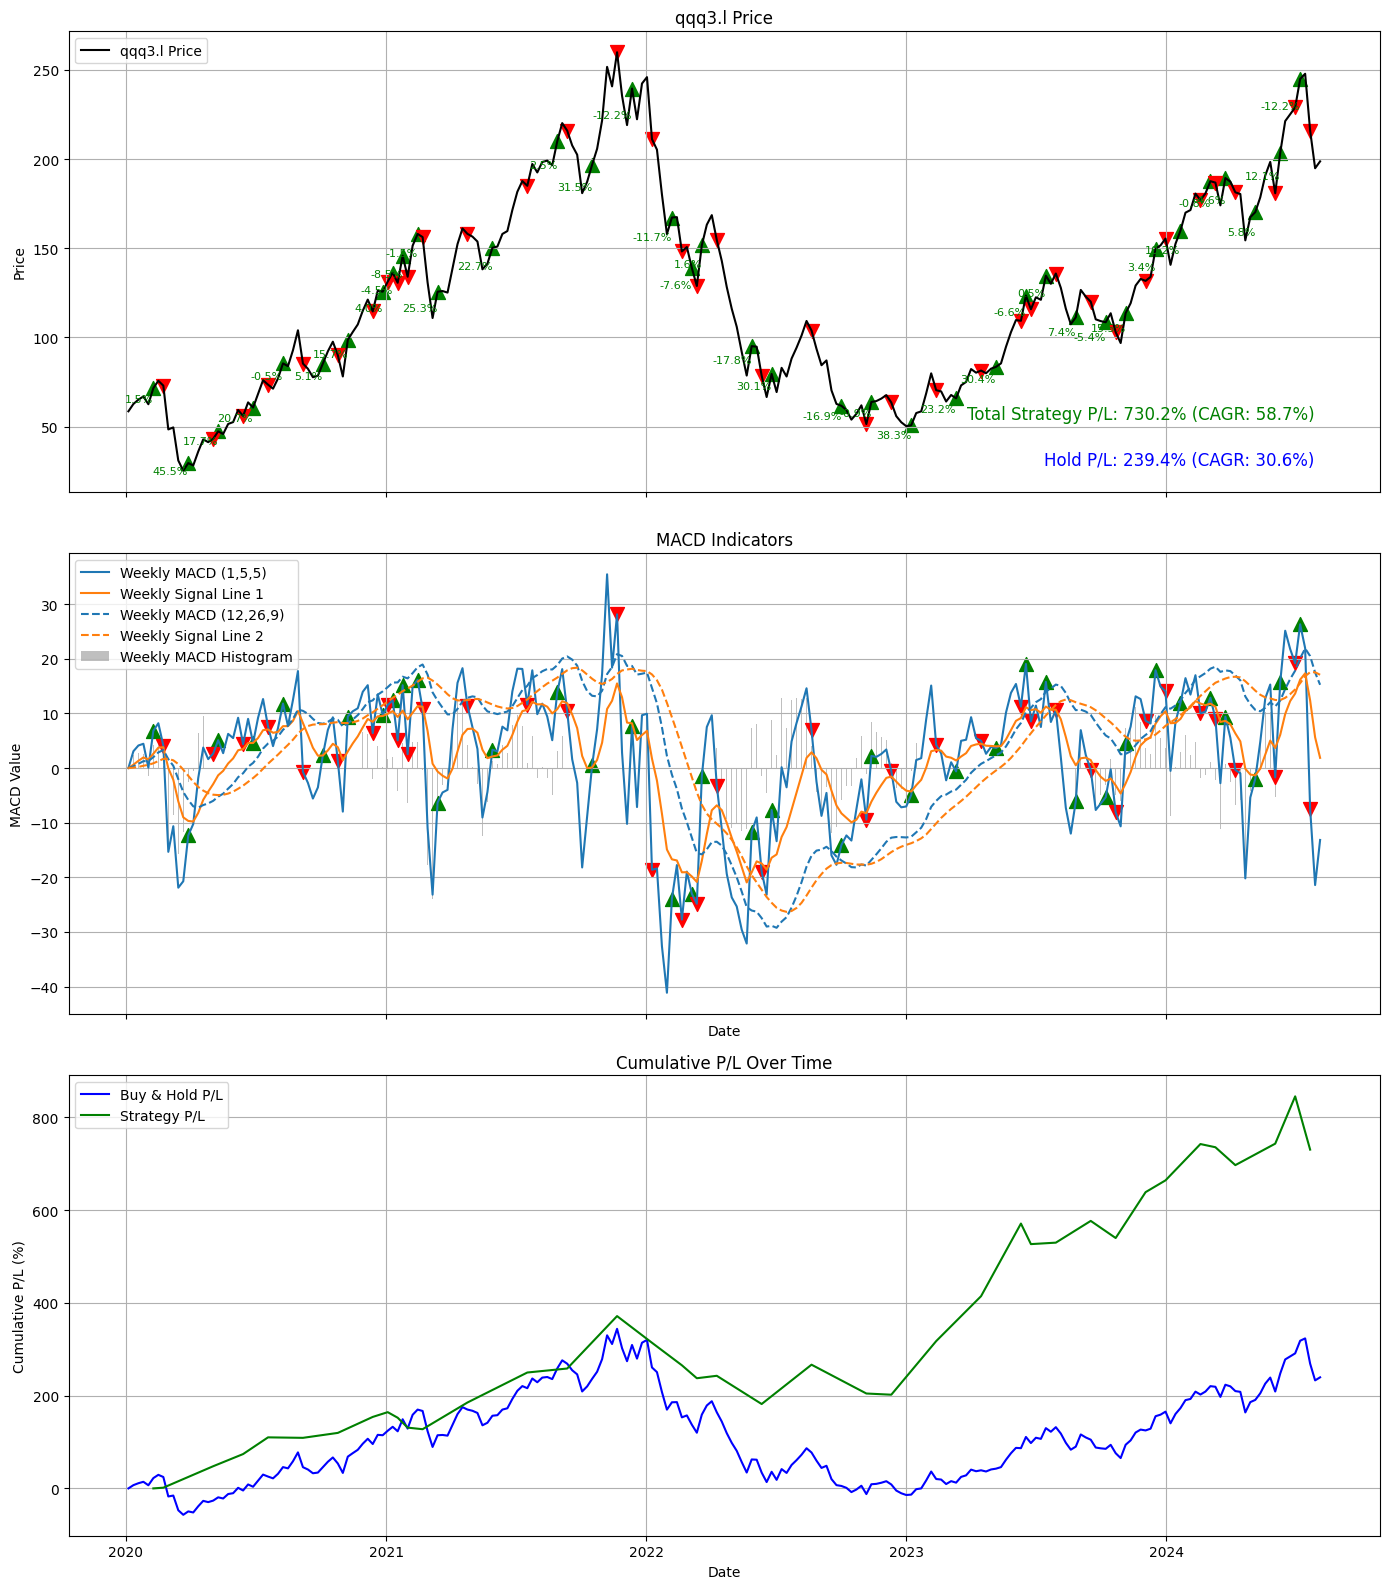

     Buy Date  Sell Date   Buy Price  Sell Price  Profit/Loss (%)
0  2020-02-09 2020-02-23   71.687951   72.789721         1.536898
1  2020-03-29 2020-05-03   29.575543   43.046254        45.546791
2  2020-05-10 2020-06-14   47.378228   55.785834        17.745715
3  2020-06-28 2020-07-19   60.759827   73.332693        20.692729
4  2020-08-09 2020-09-06   85.573592   85.148431        -0.496837
5  2020-10-04 2020-10-25   85.426463   89.783635         5.100495
6  2020-11-08 2020-12-13   98.815186  114.305934        15.676484
7  2020-12-27 2021-01-03  125.891279  130.982505         4.044145
8  2021-01-10 2021-01-17  136.547544  130.353775        -4.535979
9  2021-01-24 2021-01-31  146.061544  133.712036        -8.455003
10 2021-02-14 2021-02-21  158.295956  155.932505        -1.493058
11 2021-03-14 2021-04-25  125.851198  157.708944        25.313820
12 2021-05-30 2021-07-18  150.515426  184.620025        22.658541
13 2021-08-29 2021-09-12  210.279721  215.458219         2.462672
14 2021-10

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import numpy as np

def calculate_macd(df, short_window, long_window, signal_window, suffix=''):
    df[f'EMA_short{suffix}'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df[f'EMA_long{suffix}'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    df[f'MACD{suffix}'] = df[f'EMA_short{suffix}'] - df[f'EMA_long{suffix}']
    df[f'Signal_Line{suffix}'] = df[f'MACD{suffix}'].ewm(span=signal_window, adjust=False).mean()
    return df

def calculate_gradients(df, suffix=''):
    df[f'MACD_Gradient{suffix}'] = np.gradient(df[f'MACD{suffix}'])
    return df

def process_incremental_signals(df, short_window, long_window, signal_window, suffix=''):
    buy_signals = []
    sell_signals = []
    df = calculate_macd(df, short_window, long_window, signal_window, suffix)
    df = calculate_gradients(df, suffix)
    
    for i in range(1, len(df)-1):
        if df[f'MACD_Gradient{suffix}'].iloc[i-1] < 0 and df[f'MACD_Gradient{suffix}'].iloc[i] >= 0:
            buy_date = df.index[i+1]
            if i + 1 < len(df):
                buy_signals.append((buy_date, df['Close'].iloc[i+1], df[f'MACD{suffix}'].iloc[i+1]))  # Buy next day
        if df[f'MACD_Gradient{suffix}'].iloc[i-1] > 0 and df[f'MACD_Gradient{suffix}'].iloc[i] <= 0:
            sell_date = df.index[i+1]
            if i + 1 < len(df):
                sell_signals.append((sell_date, df['Close'].iloc[i+1], df[f'MACD{suffix}'].iloc[i+1]))  # Sell next day
    
    return buy_signals, sell_signals

def filter_signals(buy_signals, sell_signals):
    filtered_buy_signals = []
    filtered_sell_signals = []
    last_sell_date = None
    
    for buy_signal in buy_signals:
        if last_sell_date is None or buy_signal[0] > last_sell_date:
            filtered_buy_signals.append(buy_signal)
            corresponding_sell_signal = next((sell_signal for sell_signal in sell_signals if sell_signal[0] > buy_signal[0]), None)
            if corresponding_sell_signal:
                filtered_sell_signals.append(corresponding_sell_signal)
                last_sell_date = corresponding_sell_signal[0]
    
    return filtered_buy_signals, filtered_sell_signals

def calculate_profit_loss(buy_signals, sell_signals, df_price, transaction_fee=0.002):
    profit_loss = []
    cumulative_pl = []
    capital = 100  # Starting capital (arbitrary value for percentage calculation)
    trade_dates = []
    trade_records = []  # To store trade details

    for i in range(len(buy_signals)):
        buy_price = buy_signals[i][1] * (1 + transaction_fee)
        if i < len(sell_signals):
            sell_price = sell_signals[i][1] * (1 - transaction_fee)
            sell_date = sell_signals[i][0]
        else:
            sell_price = df_price['Close'].iloc[-1] * (1 - transaction_fee)
            sell_date = df_price.index[-1]
        pl = (sell_price - buy_price) / buy_price * 100
        capital *= (1 + pl / 100)
        profit_loss.append(pl)
        cumulative_pl.append(capital - 100)
        trade_dates.append((buy_signals[i][0], sell_date))
        trade_records.append({
            'Buy Date': buy_signals[i][0],
            'Sell Date': sell_date,
            'Buy Price': buy_price,
            'Sell Price': sell_price,
            'Profit/Loss (%)': pl
        })
    
    total_profit = cumulative_pl[-1] if cumulative_pl else 0
    
    return profit_loss, total_profit, cumulative_pl, trade_dates, trade_records

def plot_price_macd(df_price, df_weekly, buy_signals, sell_signals, profit_loss, hold_pl, cumulative_pl, trade_dates, trade_records):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 16), sharex=True)
    
    ax1.plot(df_price.index, df_price['Close'], label=f'{ticker} Price', color='black')
    ax1.set_title(f'{ticker} Price')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    
    for date, price, macd_value in buy_signals:
        ax1.scatter(date, price, color='green', marker='^', s=100, label='Buy Signal')
    for date, price, macd_value in sell_signals:
        ax1.scatter(date, price, color='red', marker='v', s=100, label='Sell Signal')
    
    for i, pl in enumerate(profit_loss):
        ax1.text(buy_signals[i][0], buy_signals[i][1] * 0.95, f'{pl:.1f}%', fontsize=8, color='green', ha='right', va='top')
    
    total_strategy_pl = cumulative_pl[-1] if cumulative_pl else 0
    strategy_cagr = calculate_cagr(100, total_strategy_pl + 100, df_price.index[0], df_price.index[-1])
    hold_cagr = calculate_cagr(df_price['Close'].iloc[0], df_price['Close'].iloc[-1], df_price.index[0], df_price.index[-1])
    
    ax1.text(0.95, 0.05, f'Hold P/L: {hold_pl:.1f}% (CAGR: {hold_cagr:.1f}%)', transform=ax1.transAxes, fontsize=12, color='blue', ha='right', va='bottom')
    ax1.text(0.95, 0.15, f'Total Strategy P/L: {total_strategy_pl:.1f}% (CAGR: {strategy_cagr:.1f}%)', transform=ax1.transAxes, fontsize=12, color='green', ha='right', va='bottom')

    ax2.plot(df_weekly.index, df_weekly['MACD_1'], label='Weekly MACD (1,5,5)', color='tab:blue', linewidth=1.5)
    ax2.plot(df_weekly.index, df_weekly['Signal_Line_1'], label='Weekly Signal Line 1', color='tab:orange', linestyle='-', linewidth=1.5)
    ax2.bar(df_weekly.index, df_weekly['MACD_1'] - df_weekly['Signal_Line_1'], label='Weekly MACD Histogram', color='grey', alpha=0.5)
    
    ax2.plot(df_weekly.index, df_weekly['MACD_2'], label='Weekly MACD (12,26,9)', color='tab:blue', linestyle='--', linewidth=1.5)
    ax2.plot(df_weekly.index, df_weekly['Signal_Line_2'], label='Weekly Signal Line 2', color='tab:orange', linestyle='--', linewidth=1.5)
    
    for date, price, macd_value in buy_signals:
        ax2.scatter(date, macd_value, color='green', marker='^', s=100)
    for date, price, macd_value in sell_signals:
        ax2.scatter(date, macd_value, color='red', marker='v', s=100)
    
    ax2.set_title('MACD Indicators')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('MACD Value')
    ax2.legend(loc='upper left')
    ax2.grid(True)
    
    ax3.plot(df_price.index, (df_price['Close'] / df_price['Close'].iloc[0] - 1) * 100, label='Buy & Hold P/L', color='blue')
    strategy_dates = [trade[1] for trade in trade_dates]
    strategy_dates.insert(0, trade_dates[0][0])
    cumulative_pl.insert(0, 0)
    ax3.plot(strategy_dates, cumulative_pl, label='Strategy P/L', color='green')
    ax3.set_title('Cumulative P/L Over Time')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Cumulative P/L (%)')
    ax3.legend(loc='upper left')
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

    # Display the trade table
    trade_df = pd.DataFrame(trade_records)
    print(trade_df)

def calculate_cagr(start_value, end_value, start_date, end_date):
    years = (end_date - start_date).days / 365.25
    cagr = (end_value / start_value) ** (1 / years) - 1
    return cagr * 100

if __name__ == "__main__":
    ticker = 'qqq3.l'
    start_date = '2020-01-01'
    end_date = (datetime.today() + timedelta(days=1)).strftime('%Y-%m-%d')
    df = yf.download(ticker, start=start_date, end=end_date)
    df = df.resample('W').last()
    
    buy_signals_1, sell_signals_1 = process_incremental_signals(df, 1, 7, 9, suffix='_1')
    buy_signals_2, sell_signals_2 = process_incremental_signals(df, 12, 26, 9, suffix='_2')
    
    filtered_buy_signals_1, filtered_sell_signals_1 = filter_signals(buy_signals_1, sell_signals_1)
    filtered_buy_signals_2, filtered_sell_signals_2 = filter_signals(buy_signals_2, sell_signals_2)
    
    profit_loss, total_profit, cumulative_pl, trade_dates, trade_records = calculate_profit_loss(filtered_buy_signals_1, filtered_sell_signals_1, df)
    
    start_price = df['Close'].iloc[0]
    end_price = df['Close'].iloc[-1]
    hold_pl = (end_price - start_price) / start_price * 100
    
    plot_price_macd(df, df, filtered_buy_signals_1, filtered_sell_signals_1, profit_loss, hold_pl, cumulative_pl, trade_dates, trade_records)

# ML Optimisation

In [150]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from itertools import product

def calculate_macd(df, short_window, long_window, signal_window):
    df['EMA_short'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_long'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    df['MACD'] = df['EMA_short'] - df['EMA_long']
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    return df

def calculate_gradients(df):
    df['MACD_Gradient'] = np.gradient(df['MACD'])
    return df

def find_turning_points(df):
    turning_points_buy = []
    turning_points_sell = []
    
    for i in range(1, len(df)-1):
        if df['MACD_Gradient'].iloc[i-1] < 0 and df['MACD_Gradient'].iloc[i] >= 0:
            turning_points_buy.append((df.index[i+1], df['Close'].iloc[i+1], df['MACD'].iloc[i+1]))  # Buy next day
        if df['MACD_Gradient'].iloc[i-1] > 0 and df['MACD_Gradient'].iloc[i] <= 0:
            turning_points_sell.append((df.index[i+1], df['Close'].iloc[i+1], df['MACD'].iloc[i+1]))  # Sell next day
    
    return turning_points_buy, turning_points_sell

def filter_signals(buy_signals, sell_signals):
    filtered_buy_signals = []
    filtered_sell_signals = []
    last_sell_date = None
    
    for buy_signal in buy_signals:
        if last_sell_date is None or buy_signal[0] > last_sell_date:
            filtered_buy_signals.append(buy_signal)
            corresponding_sell_signal = next((sell_signal for sell_signal in sell_signals if sell_signal[0] > buy_signal[0]), None)
            if corresponding_sell_signal:
                filtered_sell_signals.append(corresponding_sell_signal)
                last_sell_date = corresponding_sell_signal[0]
    
    return filtered_buy_signals, filtered_sell_signals

def calculate_profit_loss(buy_signals, sell_signals, df_price, transaction_fee=0.002):
    profit_loss = []
    cumulative_pl = []
    capital = 100  # Starting capital (arbitrary value for percentage calculation)
    trade_dates = []
    trade_records = []  # To store trade details

    for i in range(len(buy_signals)):
        buy_price = buy_signals[i][1] * (1 + transaction_fee)
        if i < len(sell_signals):
            sell_price = sell_signals[i][1] * (1 - transaction_fee)
            sell_date = sell_signals[i][0]
        else:
            sell_price = df_price['Close'].iloc[-1] * (1 - transaction_fee)
            sell_date = df_price.index[-1]
        pl = (sell_price - buy_price) / buy_price * 100
        capital *= (1 + pl / 100)
        profit_loss.append(pl)
        cumulative_pl.append(capital - 100)
        trade_dates.append((buy_signals[i][0], sell_date))
        trade_records.append({
            'Buy Date': buy_signals[i][0],
            'Sell Date': sell_date,
            'Buy Price': buy_price,
            'Sell Price': sell_price,
            'Profit/Loss (%)': pl
        })
    
    total_profit = cumulative_pl[-1] if cumulative_pl else 0
    
    return total_profit

def optimize_macd_parameters(df, short_window_range, long_window_range, signal_window_range):
    best_profit = -np.inf
    best_params = None
    
    for short_window, long_window, signal_window in product(short_window_range, long_window_range, signal_window_range):
        df_temp = df.copy()
        df_temp = calculate_macd(df_temp, short_window, long_window, signal_window)
        df_temp = calculate_gradients(df_temp)
        buy_signals, sell_signals = find_turning_points(df_temp)
        filtered_buy_signals, filtered_sell_signals = filter_signals(buy_signals, sell_signals)
        total_profit = calculate_profit_loss(filtered_buy_signals, filtered_sell_signals, df)
        
        if total_profit > best_profit:
            best_profit = total_profit
            best_params = (short_window, long_window, signal_window)
    
    return best_params, best_profit

if __name__ == "__main__":
    ticker = 'qqq3.l'
    start_date = '2019-01-01'
    end_date = (datetime.today() + timedelta(days=1)).strftime('%Y-%m-%d')
    df = yf.download(ticker, start=start_date, end=end_date)
    df = df.resample('W').last()
    
    short_window_range = range(1, 15)
    long_window_range = range(5, 30)
    signal_window_range = range(5, 6)
    
    best_params, best_profit = optimize_macd_parameters(df, short_window_range, long_window_range, signal_window_range)
    
    print(f"Best Parameters: Short Window: {best_params[0]}, Long Window: {best_params[1]}, Signal Window: {best_params[2]}")
    print(f"Best Profit: {best_profit:.2f}%")

[*********************100%%**********************]  1 of 1 completed


Best Parameters: Short Window: 1, Long Window: 7, Signal Window: 5
Best Profit: 1567.43%
